1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


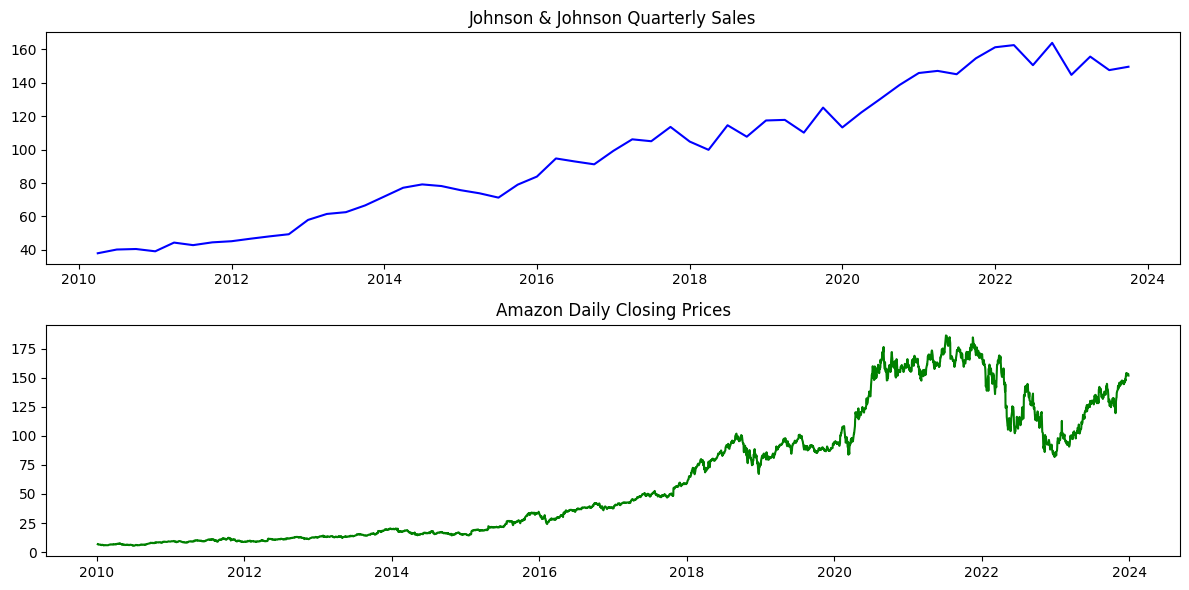

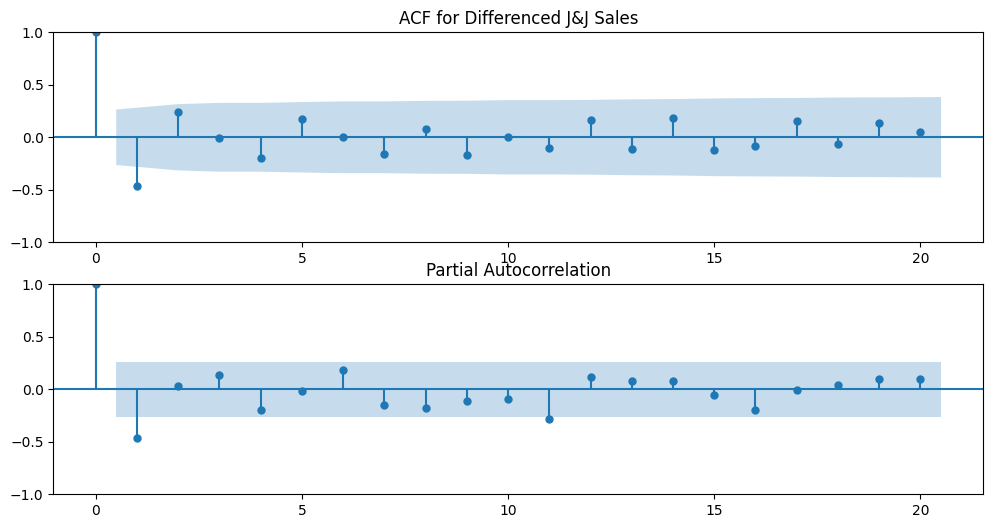

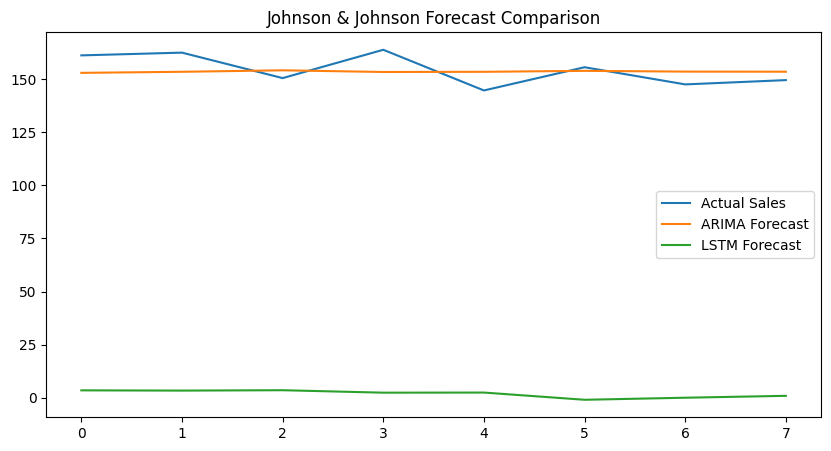

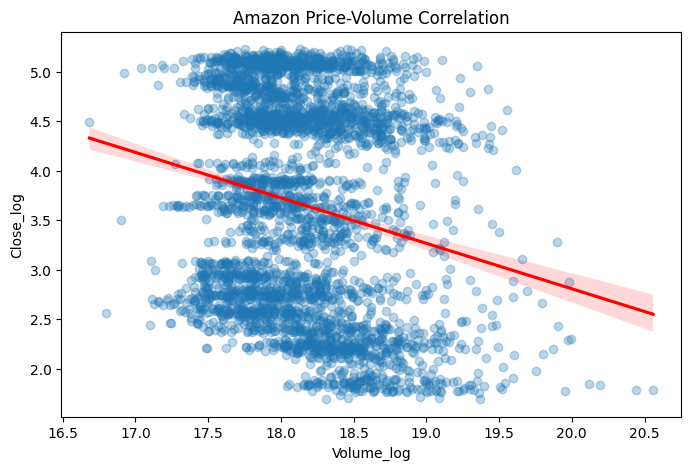

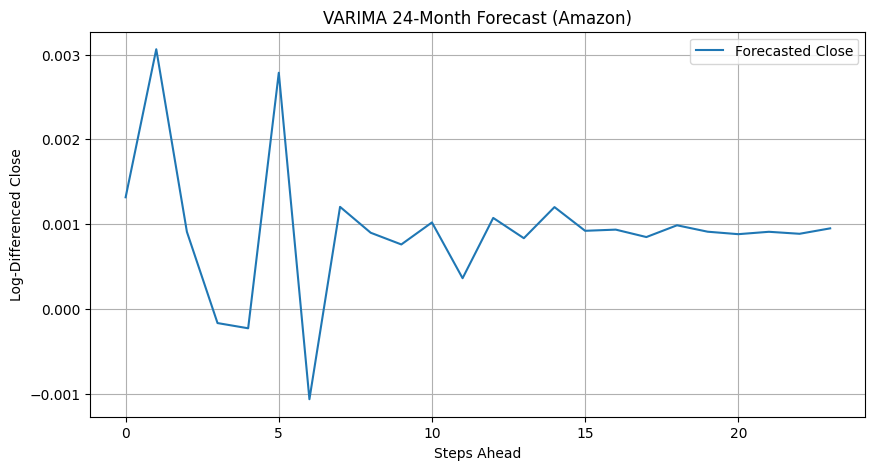

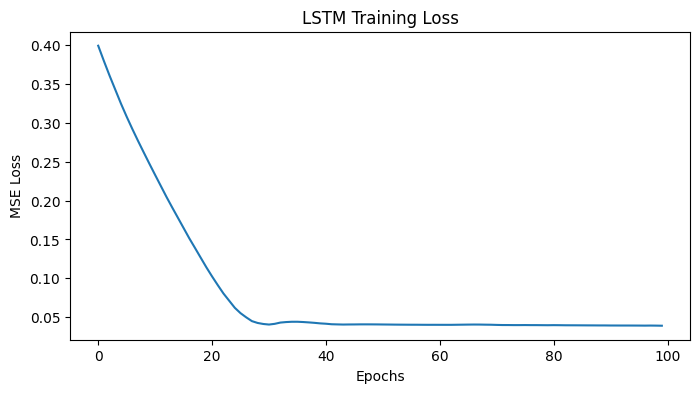

In [15]:
# Import libraries
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Forecasting Setup (before plotting)
test_size = 8
jj_full = jj_data['Sales']
jj_train = jj_full[:-test_size]
jj_test = jj_full[-test_size:]

# ARIMA Forecast
jj_arima_model = ARIMA(jj_train, order=(2, 1, 2)).fit()
arima_preds = jj_arima_model.get_forecast(steps=test_size).predicted_mean

# LSTM Forecast
jj_diff = jj_full.diff().dropna()
scaler = MinMaxScaler()
scaled = scaler.fit_transform(jj_diff.values.reshape(-1, 1))

# Create LSTM sequences
X_lstm, y_lstm = [], []
n_steps = 4
for i in range(len(scaled) - n_steps):
    X_lstm.append(scaled[i:i + n_steps, 0])
    y_lstm.append(scaled[i + n_steps, 0])
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Train-test split
X_train_lstm = X_lstm[:-test_size]
y_train_lstm = y_lstm[:-test_size]
X_test_lstm = X_lstm[-test_size:]

# Define & train LSTM
model = Sequential([
    LSTM(50, activation='relu', input_shape=(n_steps, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train_lstm.reshape((-1, n_steps, 1)), y_train_lstm, epochs=100, verbose=0)

# Predict with LSTM
lstm_preds_scaled = model.predict(X_test_lstm.reshape((-1, n_steps, 1)))
lstm_preds = scaler.inverse_transform(lstm_preds_scaled)

# Create Series for plotting
arima_preds_series = pd.Series(arima_preds.values, index=jj_test.index)
lstm_preds_series = pd.Series(lstm_preds.flatten(), index=jj_test.index)

# FIGURE 1: Raw data visualization
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(jj_data['Sales'], color='blue')
plt.title('Johnson & Johnson Quarterly Sales')
plt.subplot(2,1,2)
plt.plot(amzn_data['Close'], color='green')
plt.title('Amazon Daily Closing Prices')
plt.tight_layout()
plt.savefig('figure1_raw_data.png', dpi=300, bbox_inches='tight')

# FIGURE 2: ACF/PACF plots for J&J
plt.figure(figsize=(12,6))
plot_acf(jj_data['Sales_diff'].dropna(), lags=20, ax=plt.subplot(211))
plt.title('ACF for Differenced J&J Sales')
plot_pacf(jj_data['Sales_diff'].dropna(), lags=20, ax=plt.subplot(212))
plt.savefig('figure2_acf_pacf.png', dpi=300)

# FIGURE 3: ARIMA vs LSTM comparison
plt.figure(figsize=(10,5))
plt.plot(jj_test.values, label='Actual Sales')
plt.plot(arima_preds_series.values, label='ARIMA Forecast')
plt.plot(lstm_preds_series.values, label='LSTM Forecast')
plt.title('Johnson & Johnson Forecast Comparison')
plt.legend()
plt.savefig('figure3_forecast_comparison.png', dpi=300)

# FIGURE 4: Price-Volume Relationship (fixed source to amzn_multi)
plt.figure(figsize=(8,5))
sns.regplot(x='Volume_log', y='Close_log', data=amzn_multi,
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Amazon Price-Volume Correlation')
plt.savefig('figure4_correlation.png', dpi=300)

# FIGURE 5: VARIMA forecast
plt.figure(figsize=(10,5))
plt.plot(var_forecast[:, 0], label='Forecasted Close')
plt.title('VARIMA 24-Month Forecast (Amazon)')
plt.xlabel('Steps Ahead')
plt.ylabel('Log-Differenced Close')
plt.legend()
plt.grid(True)
plt.savefig('figure5_varima_forecast.png', dpi=300)

# FIGURE 6: LSTM training loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'])
plt.title('LSTM Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.savefig('figure6_lstm_loss.png', dpi=300)
